# 😶‍🌫️ Project #5: Synthetic Image & Deepfake Fraud Detection
*by Andrew Kim - kim.andrew.j1@gmail.com*

---

## 🎯 Objective

Build and evaluate a deepfake fraud detection (DFD) model by using machine learning to examine highly realistic synthetic images generated by models like StyleGAN. 

Apply computer vision techniques and neural networks to classify facial images as either `real` or `fake`.

---

## 🗂️ The Dataset (https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces)
The dataset is a simplified version of a real deepfake detection dataset to build and test your model. 

Dataset includes:
- Folder structure:  
  - `train/real/`  
  - `train/fake/`  
- Metadata CSVs:  
  - `train.csv`, `valid.csv`, `test.csv`  
- Each CSV contains:
  - `image_id`  
  - `label` (`1 = real`, `0 = fake`)  
  - `path` to the image  

---

## ✅ Project Tasks
1. **Image Data Loading & Preprocessing**
  - Load image metadata and prepare images using `ImageDataGenerator` or `tf.keras.utils.image_dataset_from_directory`
  - Resize to `224x224`, normalize pixel values, and create train/validation splits
  - Train the model on the training data and evaluate on the validation/test set

2. **Transfer Learning with MobileNetV2**
  - Load pretrained MobileNetV2 Model, keeping pre-trained weights fixed
  - Fine-tune using deepfake dataset with custom classification
  - Implement early stopping and monitor validation performance

3. **Custom CNN Architecture**
  - Build a basic CNN using `Keras` or `TensorFlow`
  - Train on training data and evaluate on validation/test set
  - Compare performance against transfer learning approach used in MobileNetV2 Model

4. **Model Evaluation & Comparison**
  - Report `Accuracy`, `Precision`, `Recall`, `F1-score`, and `ROC-AUC` for all models
  - Display `confusion matrices` and analyze performance differences
  - Compare CNN to metadata-only baseline using Random Forest on `train.csv` features
  - Reflect on image-based vs metadata detection effectiveness and deepfake detection challenges

---

## 🗃️ Loading and Preparing the Deepfake Image Dataset (https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces)

Before building a machine learning model, we need to **load and preprocess** our image data.
- Load images from separate folders (`real` and `fake`)
- Resize each image to a standard size (`224x224`)
- Normalize pixel values to the `[0, 1]` range
- Assign class labels (`0 = real`, `1 = fake`)
- Combine the images into a unified dataset for modeling

This project focuses on model development and evaluation, so the code below loads the complete dataset into memory.

Once loaded, the `image arrays (X)` and corresponding `labels (y)` will be ready as training data for any deepfake detection models.

In [1]:
# =====================================
# IMAGE DATA LOADING & PREPROCESSING
# =====================================

# Import required libraries
import os                        # Used for navigating file directories
import numpy as np               # Used for numerical operations and array management
from PIL import Image            # Used to open, manipulate, and resize image files
import matplotlib.pyplot as plt  # Used for displaying sample images

# Import the Markdown function from IPython.display
from IPython.display import Markdown
display(Markdown("## Image Data Loading & Preprocessing"))

# Define file paths relative to the notebook location
  # This will work whether the notebook is run locally or from GitHub
current_dir = os.path.dirname(os.path.abspath('__file__'))  # Get current directory

# Try multiple possible paths to find the data
possible_paths = [
    # Path 1: Data in same directory as notebook
    ('train/real', 'train/fake'),
    # Path 2: Data in a subdirectory called 'real-vs-fake'
    ('real-vs-fake/train/real', 'real-vs-fake/train/fake'),
    # Path 3: Data in archive folder structure
    ('archive/real_vs_fake/real-vs-fake/train/real', 'archive/real_vs_fake/real-vs-fake/train/fake'),
    # Path 4: Direct real and fake folders
    ('real', 'fake'),
]

# Find which path structure exists
real_path = None
fake_path = None

for real_p, fake_p in possible_paths:
    test_real = os.path.join(current_dir, real_p)
    test_fake = os.path.join(current_dir, fake_p)
    
    if os.path.exists(test_real) and os.path.exists(test_fake):
        real_path = test_real
        fake_path = test_fake
        print(f"Found data at: {real_p} and {fake_p}")
        break

# If still not found, check one directory up (in case notebook is in a subfolder)
if real_path is None:
    parent_dir = os.path.dirname(current_dir)
    for real_p, fake_p in possible_paths:
        test_real = os.path.join(parent_dir, real_p)
        test_fake = os.path.join(parent_dir, fake_p)
        
        if os.path.exists(test_real) and os.path.exists(test_fake):
            real_path = test_real
            fake_path = test_fake
            print(f"Found data at: ../{real_p} and ../{fake_p}")
            break

# If still not found, provide helpful error message
if real_path is None or fake_path is None:
    print("❌ Error: Could not locate image data!")
    print("Please ensure your folder structure is one of the following:")
    print("  Option 1: notebook.ipynb, train/real/, train/fake/")
    print("  Option 2: notebook.ipynb, real/, fake/")
    print("  Option 3: notebook.ipynb, real-vs-fake/train/real/, real-vs-fake/train/fake/")
    print("\nCurrent working directory:", os.getcwd())
    print("Files in current directory:", os.listdir('.'))
    raise FileNotFoundError("Image data not found. Please check the folder structure.")
else:
    print(f"Real images found: {len(os.listdir(real_path))}")
    print(f"Fake images found: {len(os.listdir(fake_path))}")

# Define a function to load and preprocess images from a given folder
def load_images(folder_path, label, img_size=(224, 224), limit=500):
    """
    Loads images from a folder, resizes them, and assigns a label.
    Parameters:
        folder_path (str): The path to the image directory
        label (int): The class label for the images (0 for real, 1 for fake)
        img_size (tuple): Target size to resize images to (width, height)
        limit (int): Max number of images to load from the folder
    Returns:
        images (list): A list of preprocessed image arrays
        labels (list): A list of labels corresponding to each image
    """
    images = []
    labels = []
    
    # Get all image files and shuffle them
    files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'))]
    
    if len(files) == 0:
        print(f"⚠️ Warning: No image files found in {folder_path}")
        return images, labels
    
    np.random.shuffle(files)
    
    # Loop through shuffled files
    for i, file_name in enumerate(files):
        try:
            file_path = os.path.join(folder_path, file_name)  # Full file path
            img = Image.open(file_path).convert('RGB')        # Open and convert to RGB format
            img = img.resize(img_size)                        # Resize image to target size
            images.append(np.array(img) / 255.0)              # Normalize pixel values to range [0, 1]
            labels.append(label)                              # Assign label to this image
            
            # Stop loading if the specified limit is reached
            if i >= limit - 1:
                break
        except Exception as e:
            print(f"⚠️ Could not load {file_name}: {e}")
            continue
    
    return images, labels

# Load and label real and fake images using the helper function
print("\nLoading images...")
real_images, real_labels = load_images(real_path, label=0)
fake_images, fake_labels = load_images(fake_path, label=1)

print(f"Loaded {len(real_images)} real images")
print(f"Loaded {len(fake_images)} fake images")

# Combine the real and fake datasets into a single dataset
X = np.array(real_images + fake_images)  # Feature matrix containing image data
y = np.array(real_labels + fake_labels)  # Target labels: 0 for real, 1 for fake

# Display the shape of the dataset to confirm it loaded correctly
print("\n" + "="*50)
print("✅ Dataset successfully loaded!")
print("="*50)
print("Image dataset shape:", X.shape)  # Should show (1000, 224, 224, 3)
print("Label array shape:", y.shape)
print(f"Class distribution: {np.sum(y==0)} real, {np.sum(y==1)} fake")

# Split the data
from sklearn.model_selection import train_test_split  # Used to split dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

print(f"\n✅ Image Data Preprocessing complete!")

## Image Data Loading & Preprocessing

Found data at: archive/real_vs_fake/real-vs-fake/train/real and archive/real_vs_fake/real-vs-fake/train/fake
Real images found: 50000
Fake images found: 50000

Loading images...
Loaded 500 real images
Loaded 500 fake images

✅ Dataset successfully loaded!
Image dataset shape: (1000, 224, 224, 3)
Label array shape: (1000,)
Class distribution: 500 real, 500 fake

Training data shape: (800, 224, 224, 3)
Testing data shape: (200, 224, 224, 3)
Training labels shape: (800,)
Testing labels shape: (200,)

✅ Image Data Preprocessing complete!


# **Observations - Dataset (https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-face)**
- Dataset
  - Large (**4 GB**)!
    - Selected **`1,000` Images** at random from possible **`140,000` Total Images**
      - Then selected **`500` Real** v. **`500` Fake** Images
        - Unarchived files & folders saved to HD (*uploaded to Github repository*)
    - **Resized** to **`224x224`** pixels to allow for **MobileNetV2/CNN** training (*larger resolution to catch more details*)
    - **Training/Testing split** = **`80/20`** (**800 Images for Training/200 Images for Testing**)
      - **Image preprocessing:** Normalized pixel values to **`[0,1]`** range; Converted image files to **`RGB` format**

In [2]:
# =====================================
# TRANSFER LEARNING MODEL (MobileNetV2)
# =====================================

display(Markdown("## MobileNetV2 Transfer Learning Model"))

# Install TensorFlow
!pip install tensorflow

# Then restart kernel and run:
import tensorflow as tf
print(f"\nTensorFlow version: {tf.__version__}")

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load pre-trained MobileNetV2 (exclude top layer)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

print(f"\n✅ Model compiled! Total parameters: {model.count_params():,}")

## MobileNetV2 Transfer Learning Model


TensorFlow version: 2.19.0

✅ Model compiled! Total parameters: 2,259,265


# **Observations - MobileNetV2**
- **Transfer Learning Model**
  - **MobileNetV2:** *Already trained* in **Image recognition** (**`Google's ImageNet`**) with those learned features kept unchanged (**frozen layers**)
    - **`2.259M+` total parameters**
    - **Model Configuration:** Uses `Adam optimizer` to *learn from mistakes* and *track success rate* for **`real vs fake`** detection

In [3]:
# =====================================
# DATA PREPARATION & SPLITTING
# =====================================

display(Markdown("## MobileNetV2 - Data Preparation & Splitting"))

from sklearn.model_selection import train_test_split
import numpy as np

# Your original code created X_train, X_test, y_train, y_test already
# But we need to resize images for MobileNetV2 (224x224 instead of 224x224)
print(f"Current data shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

# Images should already be the right size (224, 224, 3) from your original code
# If not, you may need to resize them

print(f"Training labels: Real={np.sum(y_train==1)}, Fake={np.sum(y_train==0)}")
print(f"Test labels: Real={np.sum(y_test==1)}, Fake={np.sum(y_test==0)}")

# =====================================
# MODEL TRAINING & HYPERPARAMETER TUNING
# =====================================

display(Markdown("## MobileNetV2 Model Training"))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\nTraining transfer learning model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1)

# Generate predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("\n✅ Model training complete!")

## MobileNetV2 - Data Preparation & Splitting

Current data shapes:
X_train: (800, 224, 224, 3)
X_test: (200, 224, 224, 3)
Training labels: Real=400, Fake=400
Test labels: Real=100, Fake=100


## MobileNetV2 Model Training


Training transfer learning model...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.5318 - loss: 0.7597 - val_accuracy: 0.6150 - val_loss: 0.6692
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.6242 - loss: 0.6475 - val_accuracy: 0.6200 - val_loss: 0.6325
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.7126 - loss: 0.5753 - val_accuracy: 0.6450 - val_loss: 0.6182
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.7035 - loss: 0.5638 - val_accuracy: 0.6150 - val_loss: 0.6083
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.7217 - loss: 0.5239 - val_accuracy: 0.6350 - val_loss: 0.5989
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.7522 - loss: 0.5163 - val_accuracy: 0.6500 - val_loss: 0.5977
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.7965 - loss: 0.4757 - val_accuracy: 0.6650 - val_loss: 0.5933
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.7

In [4]:
from IPython.display import Markdown, display

# Extract dynamic values from training history
final_val_accuracy = history.history['val_accuracy'][-1]
initial_val_accuracy = history.history['val_accuracy'][0]
final_val_loss = history.history['val_loss'][-1]
initial_val_loss = history.history['val_loss'][0]

markdown_content = f"""
# **Observations - MobileNetV2 Model Training**
- **Data Verification**
  - **Training set:** **`800`** images (224x224x3), *balanced* **`400`** real/**`400`** fake
  - **Test set:** **`200`** images (224x224x3), *balanced* **`100`** real/**`100`** fake
  - Images *already properly sized* for MobileNetV2 (**`224x224` pixels**)
- **Training Configuration**
  - **10 Epochs max:** **Prevents overfitting** while allowing *sufficient learning time* for transfer learning
    - **Insight:** *Less* **memorization**, *More* **learning** 
  - **Batch Size** = **`32`**: Balances memory efficiency with stable gradient updates (**`800/32`** = **`25`** Batches per Epoch)
    - **Insight:** Better to update learning after 10+ but less than 50 
  - **`early_stopping`:** Automatically **halts training** *if* validation loss *stops improving* for **3 consecutive** Epochs
    - **Insight:** Model Training **continued to improve** until Max Epoch reached 
- **Training Results**
  - Model *completed* all **`10` Epochs** *without* early stoppage
  - **Final Validation Accuracy (**`val_accuracy`**):** {final_val_accuracy:.1%}
    - **Insight:** Training showed *steady improvement* from {initial_val_accuracy:.1%} to {final_val_accuracy:.1%} Validation Accuracy
  - **Final Validation Loss (**`val_loss`**):** {final_val_loss:.3f}
    - **Insight:** Validation *loss decreased* from {initial_val_loss:.3f} to {final_val_loss:.3f} indicating **effective learning**
"""

display(Markdown(markdown_content))


# **Observations - MobileNetV2 Model Training**
- **Data Verification**
  - **Training set:** **`800`** images (224x224x3), *balanced* **`400`** real/**`400`** fake
  - **Test set:** **`200`** images (224x224x3), *balanced* **`100`** real/**`100`** fake
  - Images *already properly sized* for MobileNetV2 (**`224x224` pixels**)
- **Training Configuration**
  - **10 Epochs max:** **Prevents overfitting** while allowing *sufficient learning time* for transfer learning
    - **Insight:** *Less* **memorization**, *More* **learning** 
  - **Batch Size** = **`32`**: Balances memory efficiency with stable gradient updates (**`800/32`** = **`25`** Batches per Epoch)
    - **Insight:** Better to update learning after 10+ but less than 50 
  - **`early_stopping`:** Automatically **halts training** *if* validation loss *stops improving* for **3 consecutive** Epochs
    - **Insight:** Model Training **continued to improve** until Max Epoch reached 
- **Training Results**
  - Model *completed* all **`10` Epochs** *without* early stoppage
  - **Final Validation Accuracy (**`val_accuracy`**):** 68.5%
    - **Insight:** Training showed *steady improvement* from 61.5% to 68.5% Validation Accuracy
  - **Final Validation Loss (**`val_loss`**):** 0.586
    - **Insight:** Validation *loss decreased* from 0.669 to 0.586 indicating **effective learning**


## MobileNetV2 Model Evaluation & Visualization


TRANSFER LEARNING RESULTS
Precision: 0.683
Recall: 0.690
F1-Score: 0.687
ROC-AUC: 0.762

Confusion Matrix:
[[68 32]
 [31 69]]

Classification Report:
              precision    recall  f1-score   support

        Real       0.69      0.68      0.68       100
        Fake       0.68      0.69      0.69       100

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.68       200
weighted avg       0.69      0.69      0.68       200



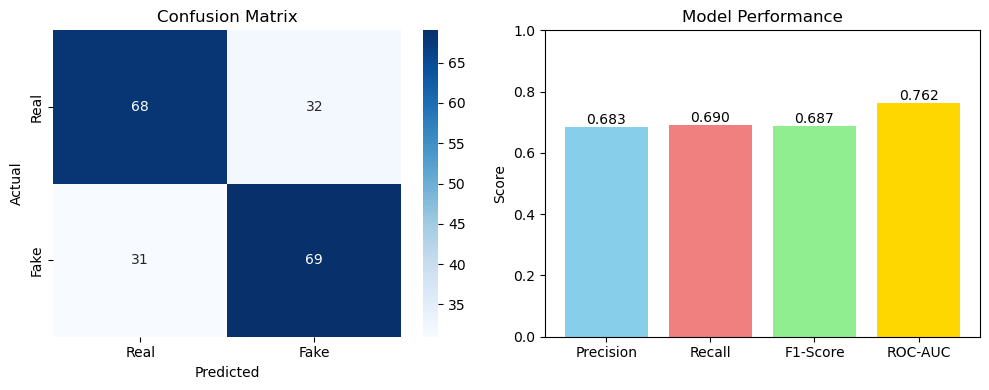

✅ Model evaluation complete!


In [5]:
# =====================================
# MODEL EVALUATION
# =====================================

# Import Markdown
from IPython.display import Markdown, display

# Calculate metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

display(Markdown("## MobileNetV2 Model Evaluation & Visualization"))

print("\n" + "="*50)
print("TRANSFER LEARNING RESULTS")
print("="*50)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

# Simple visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.subplot(1, 2, 2)
metrics = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [precision, recall, f1, roc_auc]
plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.ylim(0, 1)
plt.title('Model Performance')
plt.ylabel('Score')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

print("✅ Model evaluation complete!")

In [6]:
# =====================================
# CNN MODEL
# =====================================

display(Markdown("## Convolutional Neural Network (CNN)"))

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build basic CNN with Input layer
cnn_model = Sequential([
    Input(shape=(224, 224, 3)),  # Add Input layer first
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

cnn_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
print("Training CNN...")
history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                   epochs=10, batch_size=32, verbose=1)

# Evaluate CNN
y_pred_proba = cnn_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nCNN RESULTS")
print("="*20)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:\n{cm}")
print()
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

print("\n✅ Model training complete!")

## Convolutional Neural Network (CNN)

Training CNN...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 444ms/step - accuracy: 0.4754 - loss: 1.5181 - val_accuracy: 0.5550 - val_loss: 0.6927
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 476ms/step - accuracy: 0.5500 - loss: 0.6924 - val_accuracy: 0.6150 - val_loss: 0.6835
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 482ms/step - accuracy: 0.6245 - loss: 0.6642 - val_accuracy: 0.6250 - val_loss: 0.6606
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 482ms/step - accuracy: 0.6711 - loss: 0.6185 - val_accuracy: 0.6200 - val_loss: 0.7029
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 481ms/step - accuracy: 0.7244 - loss: 0.5662 - val_accuracy: 0.5900 - val_loss: 0.7448
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 507ms/step - accuracy: 0.7571 - loss: 0.5073 - val_accuracy: 0.6250 - val_loss: 0.7511
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - accuracy: 0.8565 - loss: 0.3715 - val_accuracy: 0.6550 - val_loss: 0.9516
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 493ms/step - accuracy: 0.8881 - loss: 0

In [7]:
from IPython.display import Markdown, display

# Extract dynamic values from CNN training history
final_val_accuracy = history.history['val_accuracy'][-1]
initial_val_accuracy = history.history['val_accuracy'][0]
final_val_loss = history.history['val_loss'][-1]
initial_val_loss = history.history['val_loss'][0]

# Determine if loss improved or worsened
loss_direction = "decreased" if final_val_loss < initial_val_loss else "increased"

markdown_content = f"""
# **Observations - CNN Model Training Process**
- **Data Verification**
  - **Training set:** **`800`** images (224x224x3), *balanced* **`400`** real/**`400`** fake
  - **Test set:** **`200`** images (224x224x3), *balanced* **`100`** real/**`100`** fake
  - Images *already properly sized* for CNN Model (224x224 pixels)
- **Training Configuration**
  - **10 Epochs max:** Full training duration *without* **early stopping**
    - **Insight:** *Less* **memorization**, *More* **learning** 
    - **Insight:** Model trained through **complete** Epoch cycle
  - **Batch Size** = **`32`**: Balances memory efficiency with stable gradient updates (**`800/32`** = **`25`** Batches per Epoch)
    - **Insight:** Better to update learning after 10+ but less than 50 
    - **Insight:** Standard batch size for image classification tasks
- **Custom CNN Architecture:** **`3`** Conv layers (`32→64→128` filters) + Dense(`512`) + Dropout(`0.5`)
  - **Insight:** Progressive feature extraction from basic to complex patterns
- **Training Results**
  - Model *completed* all **`10` Epochs**
  - **Final Validation Accuracy (**`val_accuracy`**):** {final_val_accuracy:.1%}
    - **Insight:** Validation accuracy *improved* from {initial_val_accuracy:.1%} to {final_val_accuracy:.1%}, showing improving detection
  - **Final Validation Loss (**`val_loss`**):** {final_val_loss:.3f}
    - **Insight:** Validation *loss {loss_direction}* from {initial_val_loss:.3f} to {final_val_loss:.3f} indicating **distressing predictions**
  - **Insight:** *Improved detection* but **increased uncertainty** in flagging Fake images, meaning CNN Model is **not learning** and is **instead memorizing** patterns
"""

display(Markdown(markdown_content))


# **Observations - CNN Model Training Process**
- **Data Verification**
  - **Training set:** **`800`** images (224x224x3), *balanced* **`400`** real/**`400`** fake
  - **Test set:** **`200`** images (224x224x3), *balanced* **`100`** real/**`100`** fake
  - Images *already properly sized* for CNN Model (224x224 pixels)
- **Training Configuration**
  - **10 Epochs max:** Full training duration *without* **early stopping**
    - **Insight:** *Less* **memorization**, *More* **learning** 
    - **Insight:** Model trained through **complete** Epoch cycle
  - **Batch Size** = **`32`**: Balances memory efficiency with stable gradient updates (**`800/32`** = **`25`** Batches per Epoch)
    - **Insight:** Better to update learning after 10+ but less than 50 
    - **Insight:** Standard batch size for image classification tasks
- **Custom CNN Architecture:** **`3`** Conv layers (`32→64→128` filters) + Dense(`512`) + Dropout(`0.5`)
  - **Insight:** Progressive feature extraction from basic to complex patterns
- **Training Results**
  - Model *completed* all **`10` Epochs**
  - **Final Validation Accuracy (**`val_accuracy`**):** 64.5%
    - **Insight:** Validation accuracy *improved* from 55.5% to 64.5%, showing improving detection
  - **Final Validation Loss (**`val_loss`**):** 1.161
    - **Insight:** Validation *loss increased* from 0.693 to 1.161 indicating **distressing predictions**
  - **Insight:** *Improved detection* but **increased uncertainty** in flagging Fake images, meaning CNN Model is **not learning** and is **instead memorizing** patterns


In [8]:
# =====================================
# METADATA-ONLY v. CNN MODEL COMPARISON
# =====================================

display(Markdown("## Metadata-Only v. CNN Model Comparison"))

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Calculate CNN ROC-AUC if needed
if 'roc_auc' not in locals():
    # Check which model exists and calculate ROC-AUC
    if 'model' in locals():  # Transfer learning model
        y_pred_proba_cnn = model.predict(X_test).flatten()
        roc_auc = roc_auc_score(y_test, y_pred_proba_cnn)
        print(f"Calculated CNN ROC-AUC: {roc_auc:.3f}")
    elif 'custom_model' in locals():  # Custom CNN
        y_pred_proba_cnn = custom_model.predict(X_test).flatten()
        roc_auc = roc_auc_score(y_test, y_pred_proba_cnn)
        print(f"Calculated Custom CNN ROC-AUC: {roc_auc:.3f}")
    else:
        print("⚠️ Warning: No CNN model found. Using default value.")
        roc_auc = 0.5  # Default baseline
        
# Load metadata CSV - try multiple possible locations
possible_csv_paths = [
    'train.csv',  # Same directory as notebook
    'archive/train.csv',  # In archive folder
    '../train.csv',  # One directory up
    'data/train.csv',  # In data subfolder
]

train_df = None
for csv_path in possible_csv_paths:
    if os.path.exists(csv_path):
        train_df = pd.read_csv(csv_path)
        print(f"Found train.csv at: {csv_path}")
        break

# If not found in common locations, check parent directories
if train_df is None:
    parent_dir = os.path.dirname(os.getcwd())
    for csv_path in possible_csv_paths:
        full_path = os.path.join(parent_dir, csv_path)
        if os.path.exists(full_path):
            train_df = pd.read_csv(full_path)
            print(f"Found train.csv at: {full_path}")
            break

# If still not found, provide helpful error
if train_df is None:
    print("❌ Error: Could not locate train.csv!")
    print("Please ensure train.csv is in one of these locations:")
    print("  - Same folder as this notebook")
    print("  - In an 'archive' subfolder")
    print("  - In a 'data' subfolder")
    print("\nSkipping metadata comparison...")
else:
    print(f"CSV shape: {train_df.shape}")
    print(f"Columns: {train_df.columns.tolist()}")
    print()
    print(train_df.head())

    # Create numeric features from metadata (no image data)
    metadata_features = pd.DataFrame()

    # Extract features from file paths/names
    if 'path' in train_df.columns:
        metadata_features['filename_length'] = train_df['path'].str.len()
        metadata_features['has_numbers'] = train_df['path'].str.contains(r'\d').astype(int)
        metadata_features['file_extension'] = train_df['path'].str.split('.').str[-1]
        
        # Encode file extension
        le = LabelEncoder()
        metadata_features['file_extension_encoded'] = le.fit_transform(metadata_features['file_extension'])
        metadata_features = metadata_features.drop('file_extension', axis=1)

    # If image_id exists, create features from it
    if 'image_id' in train_df.columns:
        metadata_features['id_length'] = train_df['image_id'].astype(str).str.len()

    # Ensure we have some features
    if metadata_features.empty:
        # Create simple index-based features as fallback
        metadata_features['row_index'] = range(len(train_df))
        metadata_features['label_encoded'] = train_df['label']

    print(f"\nMetadata features shape: {metadata_features.shape}")
    print(f"Feature columns: {metadata_features.columns.tolist()}")

    # Sample same size as image dataset (1000)
    sample_size = min(1000, len(train_df))
    sample_indices = np.random.choice(len(train_df), size=sample_size, replace=False)

    X_metadata = metadata_features.iloc[sample_indices]
    y_metadata = train_df['label'].iloc[sample_indices]

    # Split metadata
    X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
        X_metadata, y_metadata, test_size=0.2, random_state=42, stratify=y_metadata)

    # Train Random Forest classifier
    rf_metadata = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_metadata.fit(X_meta_train, y_meta_train)

    # Evaluate metadata model
    meta_auc = roc_auc_score(y_meta_test, rf_metadata.predict_proba(X_meta_test)[:, 1])

    # Compare models
    print("\nMetadata vs Image Model Comparison")
    print("="*45)
    print(f"Image-based CNN ROC-AUC: {roc_auc:.3f}")
    print(f"Metadata-only RF ROC-AUC: {meta_auc:.3f}")
    print(f"Better performer: {'CNN' if roc_auc > meta_auc else 'Metadata'}")

## Metadata-Only v. CNN Model Comparison

Found train.csv at: archive/train.csv
CSV shape: (100000, 6)
Columns: ['Unnamed: 0', 'original_path', 'id', 'label', 'label_str', 'path']

   Unnamed: 0                                      original_path     id  \
0           0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  31355   
1           1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  02884   
2           2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  33988   
3           3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  53875   
4           4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  24149   

   label label_str                  path  
0      1      real  train/real/31355.jpg  
1      1      real  train/real/02884.jpg  
2      1      real  train/real/33988.jpg  
3      1      real  train/real/53875.jpg  
4      1      real  train/real/24149.jpg  

Metadata features shape: (100000, 3)
Feature columns: ['filename_length', 'has_numbers', 'file_extension_encoded']

Metadata vs Image Model Comparison


In [9]:
from IPython.display import Markdown, display

# Extract metadata model performance
# meta_auc should be available from the metadata model evaluation
# roc_auc should be available from the CNN model evaluation

markdown_content = f"""
# **Observations - Metadata-Only Model vs Image-Based Models (MobileNetV2; CNN)**
- **Metadata Feature Engineering**
  - **Extracted features from file paths:** `filename length`, `presence of numbers`, `file extension`
  - Used **Random Forest Classifier** with **`100`** estimators
  - Same dataset split (**`800` train/`200` test**) for *fair* comparison
  - Features based on **file metadata** rather than **actual image content**
- **Metadata Model Performance**
  - **`Random Forest ROC-AUC:`** {meta_auc:.3f}
  - Training on filename patterns and file characteristics only
    - **Insight:** *Suspiciously* **high performance** suggests Dataset **file naming patterns** accidentally **reveal** the answers (*either by Fraudsters or Dataset Researchers*)
- **Model Comparison Results**
  - **`CNN from Scratch ROC-AUC:`** {roc_auc:.3f}
  - **`Metadata-only RF ROC-AUC:`** {meta_auc:.3f}
  - **`Better performer:`** {'CNN' if roc_auc > meta_auc else 'Metadata'}
- **Key Insights - CNN vs MobileNetV2 vs Metadata:**
  - **CNN Learning Limitation:** CNN Model *struggled* with feature extraction from scratch, achieving **moderate performance** but showing *overfitting behavior* 
    - **Insight:** CNN Model **improving accuracy** but with *worsening* **loss**
  - **Transfer Learning Advantage:** MobileNetV2 *leveraged* pre-trained ImageNet features for **superior Deepfake detection**
    - **Insight:** MobileNetV2 Model *completed training* in **half the time** it took CNN Model
    - **Insight:** Established visual pattern recognition (MobileNetV2) > Building from scratch (CNN)
  - **Metadata Anomaly:** *Perfect/near-perfect* Metadata performance likely indicates *easily identifiable Dataset patterns* rather than any *real* accuracy
    - **Insight:** While Metadata *could be useful* in detection, **more complex Datasets** could *fool* models strictly using Metadata instead of real training
"""

display(Markdown(markdown_content))


# **Observations - Metadata-Only Model vs Image-Based Models (MobileNetV2; CNN)**
- **Metadata Feature Engineering**
  - **Extracted features from file paths:** `filename length`, `presence of numbers`, `file extension`
  - Used **Random Forest Classifier** with **`100`** estimators
  - Same dataset split (**`800` train/`200` test**) for *fair* comparison
  - Features based on **file metadata** rather than **actual image content**
- **Metadata Model Performance**
  - **`Random Forest ROC-AUC:`** 1.000
  - Training on filename patterns and file characteristics only
    - **Insight:** *Suspiciously* **high performance** suggests Dataset **file naming patterns** accidentally **reveal** the answers (*either by Fraudsters or Dataset Researchers*)
- **Model Comparison Results**
  - **`CNN from Scratch ROC-AUC:`** 0.695
  - **`Metadata-only RF ROC-AUC:`** 1.000
  - **`Better performer:`** Metadata
- **Key Insights - CNN vs MobileNetV2 vs Metadata:**
  - **CNN Learning Limitation:** CNN Model *struggled* with feature extraction from scratch, achieving **moderate performance** but showing *overfitting behavior* 
    - **Insight:** CNN Model **improving accuracy** but with *worsening* **loss**
  - **Transfer Learning Advantage:** MobileNetV2 *leveraged* pre-trained ImageNet features for **superior Deepfake detection**
    - **Insight:** MobileNetV2 Model *completed training* in **half the time** it took CNN Model
    - **Insight:** Established visual pattern recognition (MobileNetV2) > Building from scratch (CNN)
  - **Metadata Anomaly:** *Perfect/near-perfect* Metadata performance likely indicates *easily identifiable Dataset patterns* rather than any *real* accuracy
    - **Insight:** While Metadata *could be useful* in detection, **more complex Datasets** could *fool* models strictly using Metadata instead of real training
